In [300]:
import imageio
import numpy as np
import porespy as ps
import openpnm as op
import scipy as sp
import scipy.ndimage as spim
import matplotlib.pyplot as plt
from porespy.filters import find_peaks, trim_saddle_points, trim_nearby_peaks
from porespy.tools import randomize_colors
from skimage.segmentation import watershed
from skimage import io
ps.settings.tqdm['disable'] = True
ps.visualization.set_mpl_style()
np.random.seed(10)

ws = op.Workspace()
ws.settings.default_solver = "ScipySpsolve"

## Functions

In [301]:
def capillary_pressure(Sw,a,b):
    Pc =a*(Sw**(-b)-1)**(1-1/b)
    return Pc
    

def rel_diff_water(Sw,poro,amq,bmq):
    Drl = poro**(amq)*(1-Sw)**(bmq)
    return Drl
    
def rel_perm_water(Sw,nk,b):
    krl = Sw**(nk)*(1-(1-Sw**b)**(1/b))**2
    return krl

def rel_perm_air(Sw,na,b):
    krl_air = (1-Sw)**(na)*(1-Sw**(1/b))**(2*b)
    return krl_air

Sw =0.5
poro = 0.465
amq = 5.
bmq = 4.2
nk =2.52
a= 6.131e7 # Pa
b = 0.512
na = 0.5

print( 'rel_diff at sat 0.5 =', rel_diff_water(Sw,poro,amq,bmq))
print('rel_perm at sat 0.5=', rel_perm_water(Sw,nk,b))
print('Capillary pressure at sat 0.5=',capillary_pressure(Sw,a,b))
print('rel_perm air=', rel_perm_air(Sw,na,b))

rel_diff at sat 0.5 = 0.00118287480814976
rel_perm at sat 0.5= 0.14296417472576825
Capillary pressure at sat 0.5= 138269153.3607082
rel_perm air= 0.5207448809213097


# Plan
" Toujours sur les epaules d'un geant"

## Mathematical modeling

### Image analysis
### Pore Network modeling
#### Intrusion
#### Transport algorithm

## Sensitivity study

## The effect of perticle size distribution: Cement paste $\mu=5.5 \mu m \pm 1.8$

### Computational homogenization




# Network extraction

In [302]:
#imdir = '/home/justin/Documents/redaction/data_tomography/beadpack.tif'
imdir ='/home/justin/Documents/redaction/data_tomography/3D_fluage_pr_pate_30b_6m_v2 1_20m_for_pnm.tif'

## Filtering

In [303]:
from skimage import color, img_as_float
im =io.imread(imdir)
#im = imageio.mimread(imdir)
#im.astype(bool)
#im = ~np.array(im)[0,...] 
#m = ~np.array(im, dtype=bool)[:, :, :] 
#im = ~np.array(im, dtype=bool)[:250, :250, :250] 
#im = img_as_float(io.imread(imdir))
#m = im[600:800,1000:1200]

sigma = 0.35
R=4

dt = spim.distance_transform_edt(input=im)
dt = spim.gaussian_filter(input=dt, sigma=sigma)
peaks=find_peaks(dt, r_max=R, sigma=sigma, divs=1)
# Apply steps of the SNOW algorithm to partition the pore space     
print('Initial number of peaks: ', spim.label(peaks)[1])
peaks = trim_saddle_points(peaks=peaks, dt=dt)
print('Peaks after trimming saddle points: ', spim.label(peaks)[1])
peaks = trim_nearby_peaks(peaks=peaks, dt=dt)
peaks, N = spim.label(peaks)
print('Peaks after trimming nearby peaks: ', N)
regions = watershed(image=-dt, markers=spim.label(peaks)[0])  


Initial number of peaks:  1160
Peaks after trimming saddle points:  1156
Peaks after trimming nearby peaks:  966


## Back to image

In [304]:
#props = ps.metrics.regionprops_3D(regions)
#plt.imshow(regions*im, origin='lower', interpolation='none');

## Extract network using SNOW of PoreSpy algorithm

In [305]:
net = ps.networks.regions_to_network(regions*im, voxel_size=1.)
pn = op.io.network_from_porespy(net)
print(net.keys())
print(pn)

dict_keys(['throat.conns', 'pore.coords', 'pore.all', 'throat.all', 'pore.region_label', 'pore.phase', 'throat.phases', 'pore.region_volume', 'pore.equivalent_diameter', 'pore.local_peak', 'pore.global_peak', 'pore.geometric_centroid', 'throat.global_peak', 'pore.inscribed_diameter', 'pore.extended_diameter', 'throat.inscribed_diameter', 'throat.total_length', 'throat.direct_length', 'throat.perimeter', 'pore.volume', 'pore.surface_area', 'throat.cross_sectional_area', 'throat.equivalent_diameter'])

══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Network at 0x7f7a0db902c0>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  throat.conns                                                  2563 / 2563
  3  pore.coords                                 

In [388]:
## Add geometric properties
from pprint import pprint
#mods = op.models.collections.geometry.spheres_and_cylinders
mods = op.models.collections.geometry.cubes_and_cuboids
#pprint(mods)
pn.add_model_collection(mods)
pn.regenerate_models()

pn['pore.diameter'] = pn['pore.equivalent_diameter']
pn['pore.volume'] = pn['pore.volume']
#pn['throat.volume'] = pn['throat.cross_sectional_area']*pn['throat.total_length']

f = op.models.geometry.throat_length.spheres_and_cylinders
pn.add_model(propname='throat.length',
             model=f)
f1 = op.models.geometry.pore_volume.sphere 
pn.add_model(propname='pore.volume',
             model=f1)
f2 = op.models.geometry.throat_volume.cylinder
pn.add_model(propname='throat.total_volume',
             model=f2)
f3 = op.models.geometry.throat_volume.lens
pn.add_model(propname='throat.lens_volume',
             model=f3)
f4 = op.models.misc.difference
pn.add_model(propname='throat.volume',
             model=f4,
             props=['throat.total_volume', 'throat.lens_volume'])
#print(pn['throat.volume'])

## Build a network with the connectivity and the pores of the extrated network

We use the pore locations and connectivity of the extrated network to build a new nwtwork where we can assign new pore size distribution, troat size distribution ..
..

### Network


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Network at 0x7f7a13be1b80>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.coords                                                     966 / 966
  3  throat.conns                                                  2563 / 2563
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Network at 0x7f7a13be1b80>
―――――――――――――――――――――――――――――

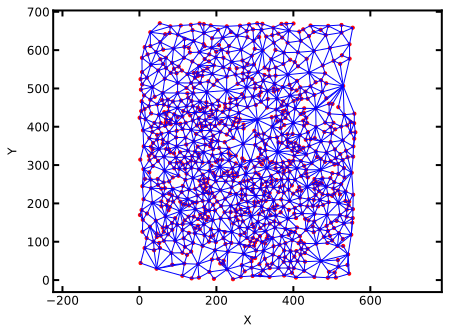

In [389]:
coords = net['pore.coords']
conns = net['throat.conns']
pn2 = op.network.Network(coords=coords, conns=conns)
print(pn2)
from pprint import pprint
mods = op.models.collections.geometry.spheres_and_cylinders
#pprint(mods)
pn2.add_model_collection(mods)
pn2.regenerate_models()
print(pn2)
ax = op.visualization.plot_connections(pn)
ax = op.visualization.plot_coordinates(pn, ax=ax)

### Porosity

We compute the porosity of the material, and found $\phi = 0.47$, which is very close to experimental results.

In [390]:
voxel_size = 7.2 # micro m
x = len(im[:,0])*voxel_size # micro m
y= len(im[:,1])*voxel_size # micro m
z= 1 # micro m
inlet_area =x*z
Vol_bulk = x*y*z
print('len(im[:,0])=',len(im[:,0]))
print('len(im[:,1])=',len(im[:,1]))
print('Vol_bulk=',len(im[:,0])*len(im[:,1]))
#print(im[:,0])
Vol_void_initial = np.sum(pn['pore.volume'])+np.sum(pn['throat.total_volume'])
print('Vol_void_initial=',Vol_void_initial)
Vol_void_corrected = np.sum(pn['pore.volume'])+np.sum(pn['throat.volume'])
print('Vol_bulk:',Vol_void_corrected)
Poro_initial = Vol_void_initial / Vol_bulk
Poro_corrected = Vol_void_corrected / Vol_bulk
print(f'Initial Porosity: {Poro_initial:.5f}')
print(f'Corrected Porosity: {Poro_corrected:.5f}')

len(im[:,0])= 564
len(im[:,1])= 564
Vol_bulk= 318096
Vol_void_initial= 694239.0627587818
Vol_bulk: 685632.3056816892
Initial Porosity: 0.04210
Corrected Porosity: 0.04158


| Method | Porosity (\%)
| --- | --- |
| This study | 47 |
| Mercury intrusion porosimetry | 46.5 |


###  Porosity size distribution

The pore size distribution is also computed fig... 
Note that the miminimun pore size capturer is $\phi=5~\mu m$ ( $r=2.5~\mu m$). We are limited by the resolution of the images !

1.4534021846451413


Text(0.5, 0, 'Throat diameter [$\\mu$m]')

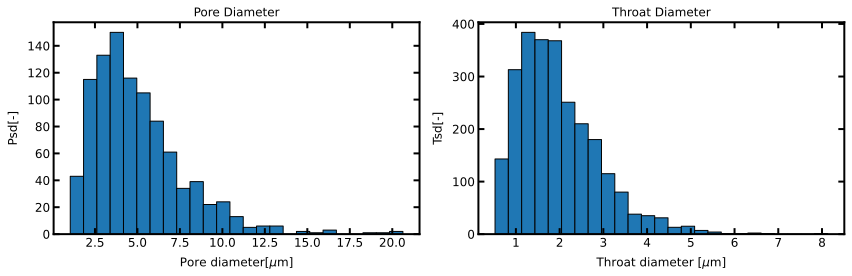

In [391]:
print(pn['pore.diameter'].min())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 4])
Pd = pn['pore.diameter']*7.2e-6 *1e5
ax1.hist(Pd, bins=25, edgecolor='k')
ax1.set_title('Pore Diameter')
Td = pn['throat.diameter']*7.2e-6*1e5
ax2.hist(Td, bins=25, edgecolor='k')
ax2.set_title('Throat Diameter');
ax1.set_ylabel('Psd[-]')
ax1.set_xlabel('Pore diameter[$\mu$m]')
ax2.set_ylabel('Tsd[-]')
ax2.set_xlabel('Throat diameter [$\mu$m]')

In [392]:
## Label right boundrary pores x =1
Ps =  pn['pore.coords'][:, 0] > 0.9* pn['pore.coords'][:, 0].max()
pn['pore.right'] = Ps
pn['pore.right'][Ps] = True
#print(pn.pores('right'))


## Label left boundary pores x= 0
Ps =  pn['pore.coords'][:, 0 ] < 50
pn['pore.left'] = Ps
pn['pore.left'][Ps] = True
#print(pn.pores('left'))

## Label bottom boundary pores z=1
Ps =  pn['pore.coords'][:, 2] > 0.9* pn['pore.coords'][:, 2].max()
pn['pore.bottom'] = Ps
pn['pore.bottom'][Ps] = True


## Label top boundary pores z=0
Ps =  pn['pore.coords'][:, 2] < 50
pn['pore.top'] = Ps
pn['pore.top'][Ps] = True


## Label back boundary pores y=1
Ps =  pn['pore.coords'][:, 1] > 0.9* pn['pore.coords'][:, 1].max()
pn['pore.back'] = Ps
pn['pore.back'][Ps] = True

## Label front boundary pores y=0
Ps =  pn['pore.coords'][:, 1] > 1.1* pn['pore.coords'][:, 1].min()
pn['pore.front'] = Ps
pn['pore.front'][Ps] = True
#print(pn.pores('front')) 

inlet = pn.pores('left')
outlet = pn.pores('right')


# Relative diffusivity

## Phases set up

In [393]:
air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072 # verifier le signe 
air['pore.contact_angle'] = 140.0   # Verifier la valeur 
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()


water = op.phase.Water(network=pn,name='water')
f = op.models.physics.capillary_pressure.washburn
water.add_model(propname='throat.entry_pressure',
             model=f, 
             surface_tension='throat.surface_tension',
             contact_angle='throat.contact_angle',
             diameter='throat.equivalent_diameter')

water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water['pore.diffusivity'] = 1e-9
water.regenerate_models()

[15:05:43] WARNING  air is already taken, using air_02 instead                                      ]8;id=821097;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/utils/_project.py\_project.py]8;;\:]8;id=383383;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/utils/_project.py#189\189]8;;\

           WARNING  water is already taken, using water_02 instead                                  ]8;id=29462;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/utils/_project.py\_project.py]8;;\:]8;id=182018;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/utils/_project.py#189\189]8;;\

In [394]:
print(water['pore.viscosity'].mean())
print(pn['throat.equivalent_diameter'])

0.0008931909474591119
[4.06842895 7.81764019 6.18038723 ... 2.98541066 3.3851375  4.37019372]


## Apply ordinary percolation

In [395]:
drn = op.algorithms.Drainage(network=pn, phase=water)
drn.set_inlet_BC(pn.pores('left'))
drn.run()

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

### Capillary pressure curve

The porosimetry experiment is ordinary percolation with access limitations. This means that a fixed pressure is applied to the invading fluid and all pores and throats that can be penetrated at that pressure are set as possibly invaded, then pores and throats are set to invaded only if they are physically connected to the source of invading fluid directly or though a path of already invading pores and throats.

To simulate mercury intrusion, we will need to calulate the capillary pressure of the throats in the network. The capillary pressure can be calculated using the Washburn equation as provided below.

$$ P_c = \frac{-2 \times \sigma \times cos(\theta)}{R_T}$$

where $R_T$ the throat radius, $\theta$ the contat angle and $\sigma$ is the surface tension of the water-air interface.

HR= [0.99989979 0.99988555 0.99986928 0.9998507  0.99982948 0.99980525
 0.99977757 0.99974596 0.99970986 0.99966862 0.99962153 0.99956775
 0.99950633 0.99943618 0.99935607 0.99926458 0.99916009 0.99904077
 0.99890451]
Pc= [0.01356265 0.01549036 0.01769207 0.02020672 0.02307879 0.02635907
 0.0301056  0.03438464 0.03927187 0.04485375 0.051229   0.05851039
 0.06682672 0.07632509 0.0871735  0.09956383 0.11371526 0.12987809
 0.14833822]


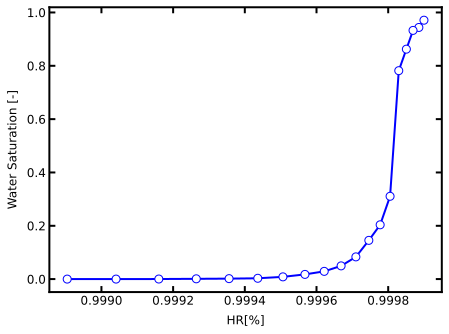

In [396]:
from sympy import diff, sin, exp 

pc = drn.pc_curve()
PC = drn.pc_curve().pc
Swp =1- drn.pc_curve().snwp
dPc= diff(Pc,Swp)

HR= np.exp(-0.018/(8.314*1000*293)*(PC*1e6))
print('HR=',HR)
print('Pc=',PC)

plt.plot(HR,Swp, 'b-o');
#plt.xlim(0.1,)
#plt.ylim(0,0.05)
plt.xlabel('HR[%]');
plt.ylabel('Water Saturation [-]');

## Drying Shinkage: Coussy 2004
$$
\varepsilon^{shr} = -\frac{-b\chi}{K}P_c
$$

$\chi= S_w$  where $S_w$ is the water saturation

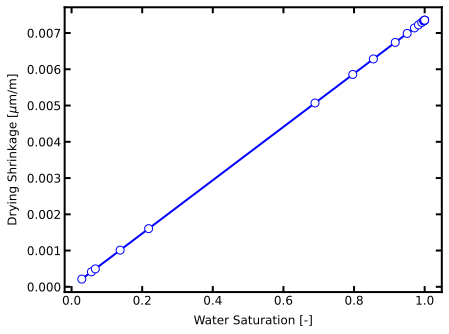

In [397]:
from sympy import diff, sin, exp 
b=0.5
K =1e1
pc = drn.pc_curve()
PC = drn.pc_curve().pc
Swp =drn.pc_curve().snwp
shr = b*Swp*Pc/K
dPc= diff(Pc,Swp)
#Swp =1-drn.pc_curve().snwp
plt.plot(Swp,shr, 'b-o');
#plt.xlim(0.1,)
#plt.ylim(0,0.05)
plt.ylabel('Drying Shrinkage [$\mu$m/m]');
plt.xlabel('Water Saturation [-]');

## Calculating absolute permeability

### Apply Stokes flow


In [398]:

flow = op.algorithms.StokesFlow(network=pn, phase=water)
flow.set_value_BC(pores=inlet, values=1)
flow.set_value_BC(pores=outlet, values=0)
flow.run()
water.update(flow.soln)

### Calculate absolute permeability

In [399]:
# NBVAL_IGNORE_OUTPUT
Q = flow.rate(pores=inlet, mode='group')[0]  # micro m ^3/s
A = inlet_area  # micro m ^2
L =  op.topotools.get_domain_length(pn, inlets=inlet, outlets=outlet)
mu = water['pore.viscosity'].mean()  # Pa.s
Delta_P = 1  # Pa
K = Q * L * mu / (A * Delta_P)
#K = Q * L / A
print(f'The value of K is: {K:.2f} e-21')

[15:05:52] WARNING  Attempting to estimate domain length...could be low if boundary pores were   ]8;id=354738;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/topotools/_topotools.py\_topotools.py]8;;\:]8;id=902521;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/topotools/_topotools.py#1074\1074]8;;\
                    not added                                                                                      

           ERROR    A unique value of length could not be found                                  ]8;id=12860;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/topotools/_topotools.py\_topotools.py]8;;\:]8;id=72300;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/topotools/_topotools.py#1084\1084]8;;\

The value of K is: 0.09 e-21


## Effective Diffusivity and Tortuosity of a Network

In this work we aim to find the effective diffusivity and torutousity of the extracted network. The effective diffusivity is defined as the diffusion coefficient multiplied by the porosity and divided by the tortuosity.
$$ D_{AB} = D_{eff}\frac{\epsilon}{\tau}$$

The tortuosity is an attempt to correct for the windy path of matter moving through a porous substance. The classical definition is the actual length divided by the direct length. In reality, there are many actual pathways that matter could move through. This means that the actual length should more precisely be thought of as the average path length.

$$ \tau = (\frac{L_{actual}}{L_{direct}})^2$$


### Performing Fickian Diffusion

We perform our Fickian diffusion simulation
The effective diffusivity of the network by solving Fick’s law is:

$$ D_{eff} = \frac{N_A \times L}{A \times \Delta C}$$

where $N_A$ (mol/s) is the molar flow rate going through the boundary pores, L is effective flow length, and $\Delta C$ is the gradient of concentration of air molecules.

We can use the effective diffusivity measured from the fickian diffusion simulation and the known diffusivity of air to solve for the tortuosity:

$$ \tau = \epsilon\frac{D_{AB}}{D_{eff}}$$



In [402]:
fd = op.algorithms.FickianDiffusion(network=pn, phase=air)
C_in, C_out = [10, 5]
fd.set_value_BC(pores=inlet, values=C_in)
fd.set_value_BC(pores=outlet, values=C_out)
fd.run();
rate_inlet = fd.rate(pores=inlet)[0]
#print(f'Molar flow rate: {rate_inlet:.5e} mol/s')
A = inlet_area  
L = y
D_eff = rate_inlet * L / (A * (C_in - C_out))
print("The effective diffusivity:  {0:.6E}".format(D_eff))

e = Vol_void_corrected / Vol_bulk
print('The porosity is: ', "{0:.6E}".format(e))
      
D_AB = air['pore.diffusivity'][0]

F = D_AB / D_eff
print(f'Formation factor is: {F:.2f}')

tau = e * D_AB / D_eff
print('The tortuosity is:', "{0:.6E}".format(tau))


The effective diffusivity:  3.088649E-05
The porosity is:  4.157843E-02
Formation factor is: 0.68
The tortuosity is: 2.819811E-02


In [318]:
water['pore.occupancy'] = drn['pore.invasion_pressure'] < 10000
water['throat.occupancy'] = drn['throat.invasion_pressure'] < 10000
air['pore.occupancy'] = 1 - water['pore.occupancy']
air['throat.occupancy'] = 1 - water['throat.occupancy']

In [319]:
def sat_update(network, nwp, wp):
    r"""
        Calculates the saturation of each phase using occupancy information from ordinary percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
    """
    pore_mask = nwp["pore.occupancy"] == 1
    throat_mask = nwp["throat.occupancy"] == 1
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    return sat

In [320]:
def Rate_calc(network, phase, inlet, outlet, conductance):
        #solver_type = sp.sparse.linalg.spsolve #op.solvers.PETScLinearSolver(tol=1e-08, maxiter=999)
        phase.regenerate_models()
        Fd = op.algorithms.FickianDiffusion(network=network, phase=phase)
        Fd.settings._update({'conductance' : conductance})
        Fd.set_value_BC(pores=inlet, values=1)
        Fd.set_value_BC(pores=outlet, values=0)
        Fd.run()
        val = np.abs(Fd.rate(pores=inlet, mode='group'))
        return val

In [321]:
diff_in = pn.pores('left')
diff_out = pn.pores('right')

In [322]:
model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_diffusive_conductance',
              throat_conductance='throat.diffusive_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_diffusive_conductance',
              throat_conductance='throat.diffusive_conductance', mode='medium', regen_mode='deferred')


In [323]:
Snwparr = []
reldiff_nwp = []
reldiff_wp = []
for Pc in np.unique(drn['pore.invasion_pressure']):
    water['pore.occupancy'] = drn['pore.invasion_pressure'] < Pc
    water['throat.occupancy'] = drn['throat.invasion_pressure'] < Pc
    air['pore.occupancy'] = 1 - water['pore.occupancy']
    air['throat.occupancy'] = 1 - water['throat.occupancy']
    air.regenerate_models()
    water.regenerate_models()
    sat_point = sat_update(pn, water, air)
    Snwparr.append(sat_point)
    Rate_single_nwp = Rate_calc(pn, air, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
    Rate_single_wp = Rate_calc(pn, water, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
    Rate_mult_nwp = Rate_calc(pn, air, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
    Rate_mult_wp = Rate_calc(pn, water, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
    reldiff_nwp.append(Rate_mult_nwp/Rate_single_nwp)
    reldiff_wp.append(Rate_mult_wp/Rate_single_wp)

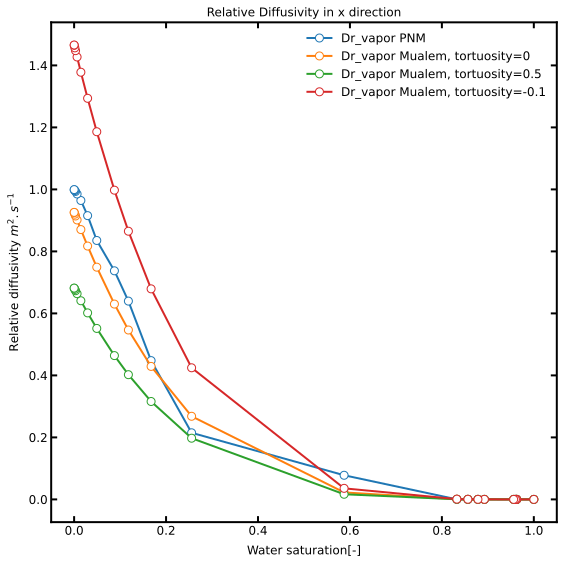

In [330]:
Snwparr =np.asarray(Snwparr)
Swp = 1-Snwparr
amq=0.1
bmq = 4.2
water_rel_diff_amq_0 = rel_diff_water(Swp,poro,amq,bmq)

amq=0.5
bmq = 4.2
water_rel_diff_amq_0p5 = rel_diff_water(Swp,poro,amq,bmq)

amq=-0.5
bmq = 4.2
water_rel_diff_amq_0pm5 = rel_diff_water(Swp,poro,amq,bmq)

amq=0
bmq = 1
air_rel_diff  = rel_diff_water(Snwparr,poro,amq,bmq)

plt.figure(figsize=[8,8])
plt.plot(Swp , reldiff_wp, 'o-', label='Dr_vapor PNM')
plt.plot(Swp , water_rel_diff_amq_0, 'o-', label='Dr_vapor Mi, tortuosity=0')
plt.plot(Swp , water_rel_diff_amq_0p5, 'o-', label='Dr_vapor Mualem, tortuosity=0.5')
plt.plot(Swp , water_rel_diff_amq_0pm5, 'o-', label='Dr_vapor Mualem, tortuosity=-0.1')
#plt.plot(Swp , reldiff_nwp, '*-', label='Dr air PNM')
#plt.plot(Swp , air_rel_diff, 'o-', label='Dr_air Mualem')
plt.xlabel('Water saturation[-]')
plt.ylabel(r'Relative diffusivity $m^{2}.s^{-1}$')
plt.title('Relative Diffusivity in x direction')
plt.legend()

## Relative permeability<?xml version="1.0" encoding="utf-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg xmlns:xlink="http://www.w3.org/1999/xlink" width="564.48pt" height="564.48pt" viewBox="0 0 564.48 564.48" xmlns="http://www.w3.org/2000/svg" version="1.1">
 <metadata>
  <rdf:RDF xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:cc="http://creativecommons.org/ns#" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">
   <cc:Work>
    <dc:type rdf:resource="http://purl.org/dc/dcmitype/StillImage"/>
    <dc:date>2022-11-21T12:46:14.219345</dc:date>
    <dc:format>image/svg+xml</dc:format>
    <dc:creator>
     <cc:Agent>
      <dc:title>Matplotlib v3.5.1, https://matplotlib.org/</dc:title>
     </cc:Agent>
    </dc:creator>
   </cc:Work>
  </rdf:RDF>
 </metadata>
 <defs>
  <style type="text/css">*{stroke-linejoin: round; stroke-linecap: butt}</style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 564.48 
L 564.48 564.48 
L 564.48 0 
L 0 0 
z
" style="fill: #ffffff"/>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 49.3975 522.5525 
L 557.28 522.5525 
L 557.28 22.318125 
L 49.3975 22.318125 
z
" style="fill: #ffffff"/>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <defs>
       <path id="m3d13316d6e" d="M 0 0 
L 0 -6 
" style="stroke: #000000; stroke-width: 2"/>
      </defs>
      <g>
       <use xlink:href="#m3d13316d6e" x="72.483068" y="522.5525" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="line2d_2">
      <defs>
       <path id="m603b7178e9" d="M 0 0 
L 0 6 
" style="stroke: #000000; stroke-width: 2"/>
      </defs>
      <g>
       <use xlink:href="#m603b7178e9" x="72.483068" y="22.318125" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="text_1">
      <!-- 0.0 -->
      <g transform="translate(62.941193 535.170625)scale(0.12 -0.12)">
       <defs>
        <path id="DejaVuSans-30" d="M 2034 4250 
Q 1547 4250 1301 3770 
Q 1056 3291 1056 2328 
Q 1056 1369 1301 889 
Q 1547 409 2034 409 
Q 2525 409 2770 889 
Q 3016 1369 3016 2328 
Q 3016 3291 2770 3770 
Q 2525 4250 2034 4250 
z
M 2034 4750 
Q 2819 4750 3233 4129 
Q 3647 3509 3647 2328 
Q 3647 1150 3233 529 
Q 2819 -91 2034 -91 
Q 1250 -91 836 529 
Q 422 1150 422 2328 
Q 422 3509 836 4129 
Q 1250 4750 2034 4750 
z
" transform="scale(0.015625)"/>
        <path id="DejaVuSans-2e" d="M 684 794 
L 1344 794 
L 1344 0 
L 684 0 
L 684 794 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-30" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_3">
      <g>
       <use xlink:href="#m3d13316d6e" x="164.835533" y="522.5525" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="line2d_4">
      <g>
       <use xlink:href="#m603b7178e9" x="164.835533" y="22.318125" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="text_2">
      <!-- 0.2 -->
      <g transform="translate(155.293658 535.170625)scale(0.12 -0.12)">
       <defs>
        <path id="DejaVuSans-32" d="M 1228 531 
L 3431 531 
L 3431 0 
L 469 0 
L 469 531 
Q 828 903 1448 1529 
Q 2069 2156 2228 2338 
Q 2531 2678 2651 2914 
Q 2772 3150 2772 3378 
Q 2772 3750 2511 3984 
Q 2250 4219 1831 4219 
Q 1534 4219 1204 4116 
Q 875 4013 500 3803 
L 500 4441 
Q 881 4594 1212 4672 
Q 1544 4750 1819 4750 
Q 2544 4750 2975 4387 
Q 3406 4025 3406 3419 
Q 3406 3131 3298 2873 
Q 3191 2616 2906 2266 
Q 2828 2175 2409 1742 
Q 1991 1309 1228 531 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-32" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_5">
      <g>
       <use xlink:href="#m3d13316d6e" x="257.187997" y="522.5525" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="line2d_6">
      <g>
       <use xlink:href="#m603b7178e9" x="257.187997" y="22.318125" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="text_3">
      <!-- 0.4 -->
      <g transform="translate(247.646122 535.170625)scale(0.12 -0.12)">
       <defs>
        <path id="DejaVuSans-34" d="M 2419 4116 
L 825 1625 
L 2419 1625 
L 2419 4116 
z
M 2253 4666 
L 3047 4666 
L 3047 1625 
L 3713 1625 
L 3713 1100 
L 3047 1100 
L 3047 0 
L 2419 0 
L 2419 1100 
L 313 1100 
L 313 1709 
L 2253 4666 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-34" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_7">
      <g>
       <use xlink:href="#m3d13316d6e" x="349.540461" y="522.5525" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="line2d_8">
      <g>
       <use xlink:href="#m603b7178e9" x="349.540461" y="22.318125" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="text_4">
      <!-- 0.6 -->
      <g transform="translate(339.998586 535.170625)scale(0.12 -0.12)">
       <defs>
        <path id="DejaVuSans-36" d="M 2113 2584 
Q 1688 2584 1439 2293 
Q 1191 2003 1191 1497 
Q 1191 994 1439 701 
Q 1688 409 2113 409 
Q 2538 409 2786 701 
Q 3034 994 3034 1497 
Q 3034 2003 2786 2293 
Q 2538 2584 2113 2584 
z
M 3366 4563 
L 3366 3988 
Q 3128 4100 2886 4159 
Q 2644 4219 2406 4219 
Q 1781 4219 1451 3797 
Q 1122 3375 1075 2522 
Q 1259 2794 1537 2939 
Q 1816 3084 2150 3084 
Q 2853 3084 3261 2657 
Q 3669 2231 3669 1497 
Q 3669 778 3244 343 
Q 2819 -91 2113 -91 
Q 1303 -91 875 529 
Q 447 1150 447 2328 
Q 447 3434 972 4092 
Q 1497 4750 2381 4750 
Q 2619 4750 2861 4703 
Q 3103 4656 3366 4563 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-36" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_9">
      <g>
       <use xlink:href="#m3d13316d6e" x="441.892926" y="522.5525" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="line2d_10">
      <g>
       <use xlink:href="#m603b7178e9" x="441.892926" y="22.318125" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="text_5">
      <!-- 0.8 -->
      <g transform="translate(432.351051 535.170625)scale(0.12 -0.12)">
       <defs>
        <path id="DejaVuSans-38" d="M 2034 2216 
Q 1584 2216 1326 1975 
Q 1069 1734 1069 1313 
Q 1069 891 1326 650 
Q 1584 409 2034 409 
Q 2484 409 2743 651 
Q 3003 894 3003 1313 
Q 3003 1734 2745 1975 
Q 2488 2216 2034 2216 
z
M 1403 2484 
Q 997 2584 770 2862 
Q 544 3141 544 3541 
Q 544 4100 942 4425 
Q 1341 4750 2034 4750 
Q 2731 4750 3128 4425 
Q 3525 4100 3525 3541 
Q 3525 3141 3298 2862 
Q 3072 2584 2669 2484 
Q 3125 2378 3379 2068 
Q 3634 1759 3634 1313 
Q 3634 634 3220 271 
Q 2806 -91 2034 -91 
Q 1263 -91 848 271 
Q 434 634 434 1313 
Q 434 1759 690 2068 
Q 947 2378 1403 2484 
z
M 1172 3481 
Q 1172 3119 1398 2916 
Q 1625 2713 2034 2713 
Q 2441 2713 2670 2916 
Q 2900 3119 2900 3481 
Q 2900 3844 2670 4047 
Q 2441 4250 2034 4250 
Q 1625 4250 1398 4047 
Q 1172 3844 1172 3481 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-38" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="xtick_6">
     <g id="line2d_11">
      <g>
       <use xlink:href="#m3d13316d6e" x="534.24539" y="522.5525" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="line2d_12">
      <g>
       <use xlink:href="#m603b7178e9" x="534.24539" y="22.318125" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="text_6">
      <!-- 1.0 -->
      <g transform="translate(524.703515 535.170625)scale(0.12 -0.12)">
       <defs>
        <path id="DejaVuSans-31" d="M 794 531 
L 1825 531 
L 1825 4091 
L 703 3866 
L 703 4441 
L 1819 4666 
L 2450 4666 
L 2450 531 
L 3481 531 
L 3481 0 
L 794 0 
L 794 531 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-31"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-30" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="text_7">
     <!-- Snwp -->
     <g transform="translate(287.01125 554.784375)scale(0.12 -0.12)">
      <defs>
       <path id="DejaVuSans-53" d="M 3425 4513 
L 3425 3897 
Q 3066 4069 2747 4153 
Q 2428 4238 2131 4238 
Q 1616 4238 1336 4038 
Q 1056 3838 1056 3469 
Q 1056 3159 1242 3001 
Q 1428 2844 1947 2747 
L 2328 2669 
Q 3034 2534 3370 2195 
Q 3706 1856 3706 1288 
Q 3706 609 3251 259 
Q 2797 -91 1919 -91 
Q 1588 -91 1214 -16 
Q 841 59 441 206 
L 441 856 
Q 825 641 1194 531 
Q 1563 422 1919 422 
Q 2459 422 2753 634 
Q 3047 847 3047 1241 
Q 3047 1584 2836 1778 
Q 2625 1972 2144 2069 
L 1759 2144 
Q 1053 2284 737 2584 
Q 422 2884 422 3419 
Q 422 4038 858 4394 
Q 1294 4750 2059 4750 
Q 2388 4750 2728 4690 
Q 3069 4631 3425 4513 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-6e" d="M 3513 2113 
L 3513 0 
L 2938 0 
L 2938 2094 
Q 2938 2591 2744 2837 
Q 2550 3084 2163 3084 
Q 1697 3084 1428 2787 
Q 1159 2491 1159 1978 
L 1159 0 
L 581 0 
L 581 3500 
L 1159 3500 
L 1159 2956 
Q 1366 3272 1645 3428 
Q 1925 3584 2291 3584 
Q 2894 3584 3203 3211 
Q 3513 2838 3513 2113 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-77" d="M 269 3500 
L 844 3500 
L 1563 769 
L 2278 3500 
L 2956 3500 
L 3675 769 
L 4391 3500 
L 4966 3500 
L 4050 0 
L 3372 0 
L 2619 2869 
L 1863 0 
L 1184 0 
L 269 3500 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-70" d="M 1159 525 
L 1159 -1331 
L 581 -1331 
L 581 3500 
L 1159 3500 
L 1159 2969 
Q 1341 3281 1617 3432 
Q 1894 3584 2278 3584 
Q 2916 3584 3314 3078 
Q 3713 2572 3713 1747 
Q 3713 922 3314 415 
Q 2916 -91 2278 -91 
Q 1894 -91 1617 61 
Q 1341 213 1159 525 
z
M 3116 1747 
Q 3116 2381 2855 2742 
Q 2594 3103 2138 3103 
Q 1681 3103 1420 2742 
Q 1159 2381 1159 1747 
Q 1159 1113 1420 752 
Q 1681 391 2138 391 
Q 2594 391 2855 752 
Q 3116 1113 3116 1747 
z
" transform="scale(0.015625)"/>
      </defs>
      <use xlink:href="#DejaVuSans-53"/>
      <use xlink:href="#DejaVuSans-6e" x="63.476562"/>
      <use xlink:href="#DejaVuSans-77" x="126.855469"/>
      <use xlink:href="#DejaVuSans-70" x="208.642578"/>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_13">
      <defs>
       <path id="mf91ed80f97" d="M 0 0 
L 6 0 
" style="stroke: #000000; stroke-width: 2"/>
      </defs>
      <g>
       <use xlink:href="#mf91ed80f97" x="49.3975" y="499.815029" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="line2d_14">
      <defs>
       <path id="ma8d2d31e21" d="M 0 0 
L -6 0 
" style="stroke: #000000; stroke-width: 2"/>
      </defs>
      <g>
       <use xlink:href="#ma8d2d31e21" x="557.28" y="499.815029" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="text_8">
      <!-- 0.0 -->
      <g transform="translate(26.81375 504.374091)scale(0.12 -0.12)">
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-30" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_15">
      <g>
       <use xlink:href="#mf91ed80f97" x="49.3975" y="408.863233" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="line2d_16">
      <g>
       <use xlink:href="#ma8d2d31e21" x="557.28" y="408.863233" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="text_9">
      <!-- 0.2 -->
      <g transform="translate(26.81375 413.422296)scale(0.12 -0.12)">
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-32" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_17">
      <g>
       <use xlink:href="#mf91ed80f97" x="49.3975" y="317.911438" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="line2d_18">
      <g>
       <use xlink:href="#ma8d2d31e21" x="557.28" y="317.911438" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="text_10">
      <!-- 0.4 -->
      <g transform="translate(26.81375 322.4705)scale(0.12 -0.12)">
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-34" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_19">
      <g>
       <use xlink:href="#mf91ed80f97" x="49.3975" y="226.959642" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="line2d_20">
      <g>
       <use xlink:href="#ma8d2d31e21" x="557.28" y="226.959642" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="text_11">
      <!-- 0.6 -->
      <g transform="translate(26.81375 231.518705)scale(0.12 -0.12)">
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-36" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_21">
      <g>
       <use xlink:href="#mf91ed80f97" x="49.3975" y="136.007847" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="line2d_22">
      <g>
       <use xlink:href="#ma8d2d31e21" x="557.28" y="136.007847" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="text_12">
      <!-- 0.8 -->
      <g transform="translate(26.81375 140.566909)scale(0.12 -0.12)">
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-38" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_6">
     <g id="line2d_23">
      <g>
       <use xlink:href="#mf91ed80f97" x="49.3975" y="45.056051" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="line2d_24">
      <g>
       <use xlink:href="#ma8d2d31e21" x="557.28" y="45.056051" style="fill: #ffffff; stroke: #000000; stroke-width: 2"/>
      </g>
     </g>
     <g id="text_13">
      <!-- 1.0 -->
      <g transform="translate(26.81375 49.615114)scale(0.12 -0.12)">
       <use xlink:href="#DejaVuSans-31"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-30" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="text_14">
     <!-- Dr -->
     <g transform="translate(16.318125 279.521875)rotate(-90)scale(0.12 -0.12)">
      <defs>
       <path id="DejaVuSans-44" d="M 1259 4147 
L 1259 519 
L 2022 519 
Q 2988 519 3436 956 
Q 3884 1394 3884 2338 
Q 3884 3275 3436 3711 
Q 2988 4147 2022 4147 
L 1259 4147 
z
M 628 4666 
L 1925 4666 
Q 3281 4666 3915 4102 
Q 4550 3538 4550 2338 
Q 4550 1131 3912 565 
Q 3275 0 1925 0 
L 628 0 
L 628 4666 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-72" d="M 2631 2963 
Q 2534 3019 2420 3045 
Q 2306 3072 2169 3072 
Q 1681 3072 1420 2755 
Q 1159 2438 1159 1844 
L 1159 0 
L 581 0 
L 581 3500 
L 1159 3500 
L 1159 2956 
Q 1341 3275 1631 3429 
Q 1922 3584 2338 3584 
Q 2397 3584 2469 3576 
Q 2541 3569 2628 3553 
L 2631 2963 
z
" transform="scale(0.015625)"/>
      </defs>
      <use xlink:href="#DejaVuSans-44"/>
      <use xlink:href="#DejaVuSans-72" x="77.001953"/>
     </g>
    </g>
   </g>
   <g id="line2d_25">
    <path d="M 72.483068 45.056051 
L 89.661584 45.056051 
L 89.955999 47.941575 
L 90.96766 52.82505 
L 92.74315 63.497778 
L 122.144094 95.148445 
L 128.610311 95.148445 
L 138.719631 122.097738 
L 149.787879 133.741565 
L 263.047387 250.340921 
L 416.229002 407.318406 
L 456.917882 451.987999 
L 479.723912 482.060093 
L 493.769338 491.77831 
L 511.49108 499.804748 
L 520.681633 499.813157 
L 527.460091 499.814131 
L 531.26999 499.814313 
L 532.820096 499.814463 
L 533.506376 499.814505 
L 534.127177 499.814549 
L 534.194432 499.814559 
" clip-path="url(#pef075036f0)" style="fill: none; stroke: #1f77b4; stroke-width: 2; stroke-linecap: square"/>
    <defs>
     <path id="m2faf4272c8" d="M 0 -4 
L -0.898056 -1.236068 
L -3.804226 -1.236068 
L -1.453085 0.472136 
L -2.351141 3.236068 
L -0 1.527864 
L 2.351141 3.236068 
L 1.453085 0.472136 
L 3.804226 -1.236068 
L 0.898056 -1.236068 
z
" style="stroke: #1f77b4; stroke-linejoin: bevel"/>
    </defs>
    <g clip-path="url(#pef075036f0)">
     <use xlink:href="#m2faf4272c8" x="72.483068" y="45.056051" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="89.661584" y="45.056051" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="89.955999" y="47.941575" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="90.96766" y="52.82505" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="92.74315" y="63.497778" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="122.144094" y="95.148445" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="128.610311" y="95.148445" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="138.719631" y="122.097738" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="149.787879" y="133.741565" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="263.047387" y="250.340921" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="416.229002" y="407.318406" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="456.917882" y="451.987999" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="479.723912" y="482.060093" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="493.769338" y="491.77831" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="511.49108" y="499.804748" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="520.681633" y="499.813157" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="527.460091" y="499.814131" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="531.26999" y="499.814313" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="532.820096" y="499.814463" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="533.506376" y="499.814505" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="534.127177" y="499.814549" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     <use xlink:href="#m2faf4272c8" x="534.194432" y="499.814559" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
    </g>
   </g>
   <g id="line2d_26">
    <path d="M 72.483068 499.814574 
L 89.661584 499.814574 
L 89.955999 499.814572 
L 90.96766 499.814569 
L 92.74315 499.814568 
L 122.144094 499.814545 
L 128.610311 499.814545 
L 138.719631 499.814524 
L 149.787879 499.814503 
L 263.047387 464.42982 
L 416.229002 402.124888 
L 456.917882 296.221598 
L 479.723912 208.908745 
L 493.769338 164.479391 
L 511.49108 119.972433 
L 520.681633 83.529863 
L 527.460091 61.315405 
L 531.26999 51.763083 
L 532.820096 48.057262 
L 533.506376 46.757157 
L 534.127177 45.707536 
L 534.194432 45.348319 
" clip-path="url(#pef075036f0)" style="fill: none; stroke: #ff7f0e; stroke-width: 2; stroke-linecap: square"/>
    <defs>
     <path id="m9f1ed1602d" d="M 0 4 
C 1.060812 4 2.078319 3.578535 2.828427 2.828427 
C 3.578535 2.078319 4 1.060812 4 0 
C 4 -1.060812 3.578535 -2.078319 2.828427 -2.828427 
C 2.078319 -3.578535 1.060812 -4 0 -4 
C -1.060812 -4 -2.078319 -3.578535 -2.828427 -2.828427 
C -3.578535 -2.078319 -4 -1.060812 -4 0 
C -4 1.060812 -3.578535 2.078319 -2.828427 2.828427 
C -2.078319 3.578535 -1.060812 4 0 4 
z
" style="stroke: #ff7f0e"/>
    </defs>
    <g clip-path="url(#pef075036f0)">
     <use xlink:href="#m9f1ed1602d" x="72.483068" y="499.814574" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="89.661584" y="499.814574" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="89.955999" y="499.814572" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="90.96766" y="499.814569" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="92.74315" y="499.814568" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="122.144094" y="499.814545" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="128.610311" y="499.814545" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="138.719631" y="499.814524" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="149.787879" y="499.814503" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="263.047387" y="464.42982" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="416.229002" y="402.124888" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="456.917882" y="296.221598" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="479.723912" y="208.908745" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="493.769338" y="164.479391" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="511.49108" y="119.972433" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="520.681633" y="83.529863" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="527.460091" y="61.315405" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="531.26999" y="51.763083" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="532.820096" y="48.057262" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="533.506376" y="46.757157" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="534.127177" y="45.707536" style="fill: #ffffff; stroke: #ff7f0e"/>
     <use xlink:href="#m9f1ed1602d" x="534.194432" y="45.348319" style="fill: #ffffff; stroke: #ff7f0e"/>
    </g>
   </g>
   <g id="patch_3">
    <path d="M 49.3975 522.5525 
L 49.3975 22.318125 
" style="fill: none; stroke: #000000; stroke-width: 2; stroke-linejoin: miter; stroke-linecap: square"/>
   </g>
   <g id="patch_4">
    <path d="M 557.28 522.5525 
L 557.28 22.318125 
" style="fill: none; stroke: #000000; stroke-width: 2; stroke-linejoin: miter; stroke-linecap: square"/>
   </g>
   <g id="patch_5">
    <path d="M 49.3975 522.5525 
L 557.28 522.5525 
" style="fill: none; stroke: #000000; stroke-width: 2; stroke-linejoin: miter; stroke-linecap: square"/>
   </g>
   <g id="patch_6">
    <path d="M 49.3975 22.318125 
L 557.28 22.318125 
" style="fill: none; stroke: #000000; stroke-width: 2; stroke-linejoin: miter; stroke-linecap: square"/>
   </g>
   <g id="text_15">
    <!-- Relative Diffusivity in x direction -->
    <g transform="translate(205.974688 16.318125)scale(0.12 -0.12)">
     <defs>
      <path id="DejaVuSans-52" d="M 2841 2188 
Q 3044 2119 3236 1894 
Q 3428 1669 3622 1275 
L 4263 0 
L 3584 0 
L 2988 1197 
Q 2756 1666 2539 1819 
Q 2322 1972 1947 1972 
L 1259 1972 
L 1259 0 
L 628 0 
L 628 4666 
L 2053 4666 
Q 2853 4666 3247 4331 
Q 3641 3997 3641 3322 
Q 3641 2881 3436 2590 
Q 3231 2300 2841 2188 
z
M 1259 4147 
L 1259 2491 
L 2053 2491 
Q 2509 2491 2742 2702 
Q 2975 2913 2975 3322 
Q 2975 3731 2742 3939 
Q 2509 4147 2053 4147 
L 1259 4147 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-65" d="M 3597 1894 
L 3597 1613 
L 953 1613 
Q 991 1019 1311 708 
Q 1631 397 2203 397 
Q 2534 397 2845 478 
Q 3156 559 3463 722 
L 3463 178 
Q 3153 47 2828 -22 
Q 2503 -91 2169 -91 
Q 1331 -91 842 396 
Q 353 884 353 1716 
Q 353 2575 817 3079 
Q 1281 3584 2069 3584 
Q 2775 3584 3186 3129 
Q 3597 2675 3597 1894 
z
M 3022 2063 
Q 3016 2534 2758 2815 
Q 2500 3097 2075 3097 
Q 1594 3097 1305 2825 
Q 1016 2553 972 2059 
L 3022 2063 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-6c" d="M 603 4863 
L 1178 4863 
L 1178 0 
L 603 0 
L 603 4863 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-61" d="M 2194 1759 
Q 1497 1759 1228 1600 
Q 959 1441 959 1056 
Q 959 750 1161 570 
Q 1363 391 1709 391 
Q 2188 391 2477 730 
Q 2766 1069 2766 1631 
L 2766 1759 
L 2194 1759 
z
M 3341 1997 
L 3341 0 
L 2766 0 
L 2766 531 
Q 2569 213 2275 61 
Q 1981 -91 1556 -91 
Q 1019 -91 701 211 
Q 384 513 384 1019 
Q 384 1609 779 1909 
Q 1175 2209 1959 2209 
L 2766 2209 
L 2766 2266 
Q 2766 2663 2505 2880 
Q 2244 3097 1772 3097 
Q 1472 3097 1187 3025 
Q 903 2953 641 2809 
L 641 3341 
Q 956 3463 1253 3523 
Q 1550 3584 1831 3584 
Q 2591 3584 2966 3190 
Q 3341 2797 3341 1997 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-74" d="M 1172 4494 
L 1172 3500 
L 2356 3500 
L 2356 3053 
L 1172 3053 
L 1172 1153 
Q 1172 725 1289 603 
Q 1406 481 1766 481 
L 2356 481 
L 2356 0 
L 1766 0 
Q 1100 0 847 248 
Q 594 497 594 1153 
L 594 3053 
L 172 3053 
L 172 3500 
L 594 3500 
L 594 4494 
L 1172 4494 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-69" d="M 603 3500 
L 1178 3500 
L 1178 0 
L 603 0 
L 603 3500 
z
M 603 4863 
L 1178 4863 
L 1178 4134 
L 603 4134 
L 603 4863 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-76" d="M 191 3500 
L 800 3500 
L 1894 563 
L 2988 3500 
L 3597 3500 
L 2284 0 
L 1503 0 
L 191 3500 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-20" transform="scale(0.015625)"/>
      <path id="DejaVuSans-66" d="M 2375 4863 
L 2375 4384 
L 1825 4384 
Q 1516 4384 1395 4259 
Q 1275 4134 1275 3809 
L 1275 3500 
L 2222 3500 
L 2222 3053 
L 1275 3053 
L 1275 0 
L 697 0 
L 697 3053 
L 147 3053 
L 147 3500 
L 697 3500 
L 697 3744 
Q 697 4328 969 4595 
Q 1241 4863 1831 4863 
L 2375 4863 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-75" d="M 544 1381 
L 544 3500 
L 1119 3500 
L 1119 1403 
Q 1119 906 1312 657 
Q 1506 409 1894 409 
Q 2359 409 2629 706 
Q 2900 1003 2900 1516 
L 2900 3500 
L 3475 3500 
L 3475 0 
L 2900 0 
L 2900 538 
Q 2691 219 2414 64 
Q 2138 -91 1772 -91 
Q 1169 -91 856 284 
Q 544 659 544 1381 
z
M 1991 3584 
L 1991 3584 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-73" d="M 2834 3397 
L 2834 2853 
Q 2591 2978 2328 3040 
Q 2066 3103 1784 3103 
Q 1356 3103 1142 2972 
Q 928 2841 928 2578 
Q 928 2378 1081 2264 
Q 1234 2150 1697 2047 
L 1894 2003 
Q 2506 1872 2764 1633 
Q 3022 1394 3022 966 
Q 3022 478 2636 193 
Q 2250 -91 1575 -91 
Q 1294 -91 989 -36 
Q 684 19 347 128 
L 347 722 
Q 666 556 975 473 
Q 1284 391 1588 391 
Q 1994 391 2212 530 
Q 2431 669 2431 922 
Q 2431 1156 2273 1281 
Q 2116 1406 1581 1522 
L 1381 1569 
Q 847 1681 609 1914 
Q 372 2147 372 2553 
Q 372 3047 722 3315 
Q 1072 3584 1716 3584 
Q 2034 3584 2315 3537 
Q 2597 3491 2834 3397 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-79" d="M 2059 -325 
Q 1816 -950 1584 -1140 
Q 1353 -1331 966 -1331 
L 506 -1331 
L 506 -850 
L 844 -850 
Q 1081 -850 1212 -737 
Q 1344 -625 1503 -206 
L 1606 56 
L 191 3500 
L 800 3500 
L 1894 763 
L 2988 3500 
L 3597 3500 
L 2059 -325 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-78" d="M 3513 3500 
L 2247 1797 
L 3578 0 
L 2900 0 
L 1881 1375 
L 863 0 
L 184 0 
L 1544 1831 
L 300 3500 
L 978 3500 
L 1906 2253 
L 2834 3500 
L 3513 3500 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-64" d="M 2906 2969 
L 2906 4863 
L 3481 4863 
L 3481 0 
L 2906 0 
L 2906 525 
Q 2725 213 2448 61 
Q 2172 -91 1784 -91 
Q 1150 -91 751 415 
Q 353 922 353 1747 
Q 353 2572 751 3078 
Q 1150 3584 1784 3584 
Q 2172 3584 2448 3432 
Q 2725 3281 2906 2969 
z
M 947 1747 
Q 947 1113 1208 752 
Q 1469 391 1925 391 
Q 2381 391 2643 752 
Q 2906 1113 2906 1747 
Q 2906 2381 2643 2742 
Q 2381 3103 1925 3103 
Q 1469 3103 1208 2742 
Q 947 2381 947 1747 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-63" d="M 3122 3366 
L 3122 2828 
Q 2878 2963 2633 3030 
Q 2388 3097 2138 3097 
Q 1578 3097 1268 2742 
Q 959 2388 959 1747 
Q 959 1106 1268 751 
Q 1578 397 2138 397 
Q 2388 397 2633 464 
Q 2878 531 3122 666 
L 3122 134 
Q 2881 22 2623 -34 
Q 2366 -91 2075 -91 
Q 1284 -91 818 406 
Q 353 903 353 1747 
Q 353 2603 823 3093 
Q 1294 3584 2113 3584 
Q 2378 3584 2631 3529 
Q 2884 3475 3122 3366 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-6f" d="M 1959 3097 
Q 1497 3097 1228 2736 
Q 959 2375 959 1747 
Q 959 1119 1226 758 
Q 1494 397 1959 397 
Q 2419 397 2687 759 
Q 2956 1122 2956 1747 
Q 2956 2369 2687 2733 
Q 2419 3097 1959 3097 
z
M 1959 3584 
Q 2709 3584 3137 3096 
Q 3566 2609 3566 1747 
Q 3566 888 3137 398 
Q 2709 -91 1959 -91 
Q 1206 -91 779 398 
Q 353 888 353 1747 
Q 353 2609 779 3096 
Q 1206 3584 1959 3584 
z
" transform="scale(0.015625)"/>
     </defs>
     <use xlink:href="#DejaVuSans-52"/>
     <use xlink:href="#DejaVuSans-65" x="64.982422"/>
     <use xlink:href="#DejaVuSans-6c" x="126.505859"/>
     <use xlink:href="#DejaVuSans-61" x="154.289062"/>
     <use xlink:href="#DejaVuSans-74" x="215.568359"/>
     <use xlink:href="#DejaVuSans-69" x="254.777344"/>
     <use xlink:href="#DejaVuSans-76" x="282.560547"/>
     <use xlink:href="#DejaVuSans-65" x="341.740234"/>
     <use xlink:href="#DejaVuSans-20" x="403.263672"/>
     <use xlink:href="#DejaVuSans-44" x="435.050781"/>
     <use xlink:href="#DejaVuSans-69" x="512.052734"/>
     <use xlink:href="#DejaVuSans-66" x="539.835938"/>
     <use xlink:href="#DejaVuSans-66" x="575.041016"/>
     <use xlink:href="#DejaVuSans-75" x="610.246094"/>
     <use xlink:href="#DejaVuSans-73" x="673.625"/>
     <use xlink:href="#DejaVuSans-69" x="725.724609"/>
     <use xlink:href="#DejaVuSans-76" x="753.507812"/>
     <use xlink:href="#DejaVuSans-69" x="812.6875"/>
     <use xlink:href="#DejaVuSans-74" x="840.470703"/>
     <use xlink:href="#DejaVuSans-79" x="879.679688"/>
     <use xlink:href="#DejaVuSans-20" x="938.859375"/>
     <use xlink:href="#DejaVuSans-69" x="970.646484"/>
     <use xlink:href="#DejaVuSans-6e" x="998.429688"/>
     <use xlink:href="#DejaVuSans-20" x="1061.808594"/>
     <use xlink:href="#DejaVuSans-78" x="1093.595703"/>
     <use xlink:href="#DejaVuSans-20" x="1152.775391"/>
     <use xlink:href="#DejaVuSans-64" x="1184.5625"/>
     <use xlink:href="#DejaVuSans-69" x="1248.039062"/>
     <use xlink:href="#DejaVuSans-72" x="1275.822266"/>
     <use xlink:href="#DejaVuSans-65" x="1314.685547"/>
     <use xlink:href="#DejaVuSans-63" x="1376.208984"/>
     <use xlink:href="#DejaVuSans-74" x="1431.189453"/>
     <use xlink:href="#DejaVuSans-69" x="1470.398438"/>
     <use xlink:href="#DejaVuSans-6f" x="1498.181641"/>
     <use xlink:href="#DejaVuSans-6e" x="1559.363281"/>
    </g>
   </g>
   <g id="legend_1">
    <g id="line2d_27">
     <path d="M 60.1975 262.405937 
L 72.1975 262.405937 
L 84.1975 262.405937 
" style="fill: none; stroke: #1f77b4; stroke-width: 2; stroke-linecap: square"/>
     <g>
      <use xlink:href="#m2faf4272c8" x="72.1975" y="262.405937" style="fill: #ffffff; stroke: #1f77b4; stroke-linejoin: bevel"/>
     </g>
    </g>
    <g id="text_16">
     <!-- Dr_nwp -->
     <g transform="translate(93.7975 266.605937)scale(0.12 -0.12)">
      <defs>
       <path id="DejaVuSans-5f" d="M 3263 -1063 
L 3263 -1509 
L -63 -1509 
L -63 -1063 
L 3263 -1063 
z
" transform="scale(0.015625)"/>
      </defs>
      <use xlink:href="#DejaVuSans-44"/>
      <use xlink:href="#DejaVuSans-72" x="77.001953"/>
      <use xlink:href="#DejaVuSans-5f" x="118.115234"/>
      <use xlink:href="#DejaVuSans-6e" x="168.115234"/>
      <use xlink:href="#DejaVuSans-77" x="231.494141"/>
      <use xlink:href="#DejaVuSans-70" x="313.28125"/>
     </g>
    </g>
    <g id="line2d_28">
     <path d="M 60.1975 280.353437 
L 72.1975 280.353437 
L 84.1975 280.353437 
" style="fill: none; stroke: #ff7f0e; stroke-width: 2; stroke-linecap: square"/>
     <g>
      <use xlink:href="#m9f1ed1602d" x="72.1975" y="280.353437" style="fill: #ffffff; stroke: #ff7f0e"/>
     </g>
    </g>
    <g id="text_17">
     <!-- Dr_wp -->
     <g transform="translate(93.7975 284.553437)scale(0.12 -0.12)">
      <use xlink:href="#DejaVuSans-44"/>
      <use xlink:href="#DejaVuSans-72" x="77.001953"/>
      <use xlink:href="#DejaVuSans-5f" x="118.115234"/>
      <use xlink:href="#DejaVuSans-77" x="168.115234"/>
      <use xlink:href="#DejaVuSans-70" x="249.902344"/>
     </g>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clipPath id="pef075036f0">
   <rect x="49.3975" y="22.318125" width="507.8825" height="500.234375"/>
  </clipPath>
 </defs>
</svg>


In [331]:
air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 180.0
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()
water = op.phase.Water(network=pn,name='water')
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water.regenerate_models()

[13:25:27] WARNING  air is already taken, using air_01 instead                                      ]8;id=609263;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/utils/_project.py\_project.py]8;;\:]8;id=51280;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/utils/_project.py#189\189]8;;\

           WARNING  water is already taken, using water_01 instead                                  ]8;id=536763;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/utils/_project.py\_project.py]8;;\:]8;id=615664;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/utils/_project.py#189\189]8;;\

[13:25:28] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=352329;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=441187;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

In [332]:
ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
Finlets_init = pn.pores('right')
Finlets=([Finlets_init[x] for x in range(0, len(Finlets_init), 2)])
ip.set_inlet_BC(pores=Finlets)
ip.run()

In [333]:
def sat_occ_update(network, nwp, wp, ip, i):
    r"""
        Calculates the saturation of each phase using the invasion
        sequence from either invasion percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        ip : IP
            invasion percolation (ran before calling this function)
        i: int
            The invasion_sequence limit for masking pores/throats that
            have already been invaded within this limit range. The
            saturation is found by adding the volume of pores and thorats
            that meet this sequence limit divided by the bulk volume.
    """
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

In [334]:
def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val

In [335]:
flow_in = pn.pores('left')
flow_out = pn.pores('right')

In [336]:
model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

In [337]:
Snwp_num=60
flow_in = pn.pores('left')
flow_out = pn.pores('right')
max_seq = np.max([np.max(ip['pore.invasion_sequence']),
          np.max(ip['throat.invasion_sequence'])])
start = max_seq//Snwp_num
stop = max_seq
step = max_seq//Snwp_num
Snwparr = []
relperm_nwp = []
relperm_wp = []

In [338]:
for i in range(start, stop, step):
    air.regenerate_models();
    water.regenerate_models();
    sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
    Snwparr.append(sat)
    Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
    Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
    Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
    Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
    relperm_nwp.append(Rate_enwp/Rate_abs_nwp)
    relperm_wp.append(Rate_ewp/Rate_abs_wp)

[13:25:31] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=50106;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=554358;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=68227;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=802239;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=94411;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=351091;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=46683;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=184442;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[13:25:32] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=916492;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=521629;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=758702;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=287533;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=120696;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=238850;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=865511;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=21771;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=858254;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=74493;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=769762;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=579852;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=910185;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=237361;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=3224;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=757802;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=655222;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=899104;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=948798;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=118950;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=134639;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=797471;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=256462;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=794889;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=277933;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=205532;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=494897;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=548516;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=398498;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=845827;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=859881;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=109952;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=25211;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=832828;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[13:25:33] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=101546;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=642774;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=613994;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=353914;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=207383;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=804774;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=43594;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=433995;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=657658;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=370581;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=599226;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=988858;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=12681;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=813090;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=100137;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=963197;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=381845;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=184831;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=796239;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=15659;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=105418;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=555989;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=563375;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=789098;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=904877;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=788085;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=542151;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=76334;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=595505;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=625109;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=965373;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=268937;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=573028;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=569255;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[13:25:34] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=797181;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=948270;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=807810;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=409321;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=20891;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=383442;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=630985;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=168780;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=307388;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=77321;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=990320;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=289583;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=558008;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=774427;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=394704;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=649872;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=528830;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=377271;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=719795;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=786142;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=208107;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=346558;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=579943;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=634489;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=45421;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=432179;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=388850;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=674261;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=186176;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=744301;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=635055;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=339345;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=132745;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=751573;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[13:25:35] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=234957;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=94381;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=264209;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=235095;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=254754;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=258703;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=324961;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=548430;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=319663;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=69460;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=954049;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=156451;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=817386;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=900699;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=349960;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=684531;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=806165;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=444474;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=130262;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=44043;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=447887;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=191830;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=920069;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=816327;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=60025;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=658963;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=106277;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=816473;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=959971;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=951673;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=914412;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=893636;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=166626;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=244979;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=404598;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=637770;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[13:25:36] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=179924;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=453947;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=607905;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=512690;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=147223;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=156498;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=728576;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=250454;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=599348;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=675658;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=225068;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=290860;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=608921;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=551600;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=951513;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=762875;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=833109;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=291112;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=700924;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=331971;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=569687;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=928358;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=867570;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=5732;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=703899;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=421340;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=476117;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=262620;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=142033;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=586167;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=943748;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=336638;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=594316;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=437054;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=21350;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=717447;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=517509;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=581667;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[13:25:37] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=662759;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=880746;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=824906;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=152695;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=500133;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=814589;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=485097;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=514567;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=515498;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=335208;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=951625;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=422443;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=611494;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=881085;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=220137;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=67544;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=508883;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=184899;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=800367;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=636574;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=478990;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=703438;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=28841;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=145764;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=567880;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=644644;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=994267;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=49418;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=1355;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=752667;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=470185;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=429699;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=414682;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=455689;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=72616;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=512249;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[13:25:38] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=982962;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=360206;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=81828;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=810820;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=914900;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=193732;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=48478;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=6576;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=943840;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=944743;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=189676;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=394169;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=331554;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=325518;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=284653;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=561010;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=813209;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=94535;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=407201;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=6541;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=684968;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=145511;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=190798;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=684557;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=950810;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=578047;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=238856;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=766963;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=433834;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=73214;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=505725;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=171669;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=418341;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=364434;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[13:25:39] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=296607;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=107468;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=292982;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=542822;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=550580;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=740701;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=3515;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=532612;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=26343;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=766003;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=546444;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=233779;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=59737;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=158315;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=261251;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=400314;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=24235;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=357949;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=360257;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=224621;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=205132;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=757832;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=681157;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=240833;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=678993;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=270786;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=479490;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=219748;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=936728;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=260909;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[13:25:40] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=164246;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=710032;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=352896;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=941069;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=868516;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=980032;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=376797;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=861126;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=699899;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=604741;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=88161;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=535374;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=719388;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=316341;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=174053;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=234055;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=639531;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=256113;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=851716;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=281988;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=275178;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=263392;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=633298;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=438586;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=807588;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=145903;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=217018;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=744714;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=233334;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=920733;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=396557;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=768423;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=605072;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=589293;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=136780;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=59401;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[13:25:41] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=291460;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=734426;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=710630;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=413515;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=650976;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=178406;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=266723;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=919309;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=438041;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=168670;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=24429;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=728851;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=329197;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=147343;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=310305;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=254046;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=853117;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=263197;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=3579;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=317999;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=62284;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=486089;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=290732;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=345638;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=142542;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=277603;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=932323;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=858151;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=631004;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=73284;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=601174;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=5448;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=745685;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=409299;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=226066;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=960545;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=358638;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=319253;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[13:25:42] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=279864;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=444257;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=767807;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=468938;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=995765;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=313435;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=245977;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=615433;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=535724;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=750820;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=700837;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py\_models.py]8;;\:]8;id=428611;file:///home/justin/miniconda3/lib/python3.9/site-packages/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

## Empirical formulas for relative permeability of water and air:

$$
\begin{aligned}
&k^{r g}=\sqrt{\left(1-S_l\right)}\left(1-S_l^{1 / m}\right)^{2 m}, \\
&k^{r l}=\sqrt{S_l}\left[1-\left(1-S_l^{1 / m}\right)^m\right]^2,
\end{aligned}
$$


exp_perm= [5.22067363e-01 4.41852792e-01 3.97852999e-01 2.53165782e-01
 1.93914583e-01 1.75376704e-01 1.45185765e-01 1.05669798e-01
 5.75599656e-02 4.05551278e-02 3.69016593e-02 3.27148058e-02
 2.76736450e-02 2.31729069e-02 1.42923198e-02 9.99807879e-03
 8.14101228e-03 6.61254809e-03 5.56535846e-03 4.67960298e-03
 4.22566641e-03 3.95749819e-03 3.21322515e-03 2.72516625e-03
 2.13286843e-03 1.84844152e-03 1.60649880e-03 1.36635368e-03
 1.26285531e-03 1.03642082e-03 7.98000886e-04 7.35417875e-04
 5.97701155e-04 5.50545557e-04 3.54974109e-04 3.18586395e-04
 2.25756723e-04 2.02410652e-04 1.72150985e-04 1.35975812e-04
 7.51754689e-05 6.00342521e-05 4.62773629e-05 3.21935038e-05
 2.43071118e-05 1.75329779e-05 1.15354836e-05 7.35022270e-06
 4.90768758e-06 3.32968220e-06 1.38389244e-06 1.15841734e-06
 6.40142807e-07 2.69480170e-07 1.13622685e-07 4.59246654e-08
 1.33176523e-08 5.16103970e-09 1.37077572e-09 1.49625523e-10
            nan]
61
61


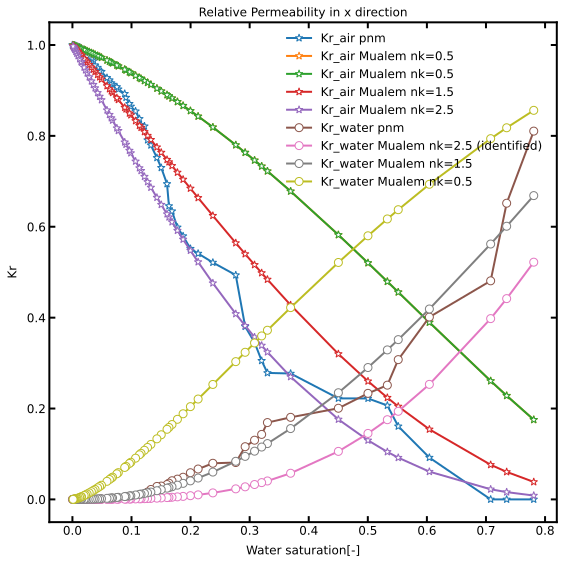

In [339]:
nk1 =2.5
nk2 =1.5
factor = 1
na =0.5
Swp = 1-np.asarray(Snwparr)
water_perm_mualem_nk_2p5 = factor*rel_perm_water(Swp,2.5,b)
water_perm_mualem_nk_1p5 = factor*rel_perm_water(Swp,1.5,b)
water_perm_mualem_nk_0p5 = factor*rel_perm_water(Swp,0.5,b)


air_perm_mualem_na_0p5 = rel_perm_air(Swp,0.5,b)
air_perm_mualem_na_1p5 = rel_perm_air(Swp,1.5,b)
air_perm_mualem_na_2p5 = rel_perm_air(Swp,2.5,b)


print('exp_perm=',exp_perm)
print(len(exp_perm))
print(len(Swp))

plt.figure(figsize=[8,8])
plt.plot(Swp, relperm_nwp, '*-', label='Kr_air pnm')
plt.plot(Swp, air_perm_mualem_na_0p5, '*-', label='Kr_air Mualem nk=0.5 ')
plt.plot(Swp, air_perm_mualem_na_0p5, '*-', label='Kr_air Mualem nk=0.5')
plt.plot(Swp, air_perm_mualem_na_1p5, '*-', label='Kr_air Mualem nk=1.5')
plt.plot(Swp, air_perm_mualem_na_2p5, '*-', label='Kr_air Mualem nk=2.5')
plt.plot(Swp, relperm_wp, 'o-', label='Kr_water pnm')
plt.plot(Swp, water_perm_mualem_nk_2p5, 'o-', label='Kr_water Mualem nk=2.5 (identified) ')
plt.plot(Swp, water_perm_mualem_nk_1p5, 'o-', label='Kr_water Mualem nk=1.5 ')
plt.plot(Swp, water_perm_mualem_nk_0p5, 'o-', label='Kr_water Mualem nk=0.5 ')


plt.xlabel('Water saturation[-]')
plt.ylabel('Kr')
plt.title('Relative Permeability in x direction')
plt.legend()

## Comparison with experimental identification

Discussion points :
- A plateau of perabiniliy of water between 0.27 and 0.23
- Permeability equal zero below saturation of 0.11
- Permeability of air is zero above saturation of 0.63 
- Permeability of air more dominat when saturation become lwer than 0.45